<a href="https://colab.research.google.com/github/sugiyama404/forecast_sp500/blob/main/ex_fc1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM,GRU

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from google.colab import drive

In [2]:
# データ読み込み
drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/dataset/'  # このフォルダへのパス
nov_path = '/content/drive/My Drive/' + nov_dir + 'data_csv_sp500.csv'

df = pd.read_csv(nov_path)
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

#データの標準化
df['SP500'] = preprocessing.scale(df['SP500'])

#訓練、テストデータの作成
maxlen = 10
X, Y = [], []
for i in range(len(df) - maxlen):
    X.append(df[['SP500']].iloc[i:(i+maxlen)].values)
    Y.append(df[['SP500']].iloc[i+maxlen].values)
X=np.array(X)
Y=np.array(Y)

# 訓練用のデータと、テスト用のデータに分ける
N_train = int(len(df) * 0.8)
N_test = len(df) - N_train
X_train, X_test, y_train, y_test = \
    train_test_split(X, Y, test_size=N_test, shuffle = False) 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# 隠れ層の数などを定義: 隠れ層の数が大きいほど精度が上がる?
n_in = 1
n_mid = 20
n_out = 1
batch_size = 8  # バッチサイズ

model = Sequential()
model.add(GRU(n_mid,
               batch_input_shape=(None, maxlen, n_in),
               kernel_initializer='random_uniform',
               return_sequences=False))
model.add(Dense(n_in, kernel_initializer='random_uniform'))
model.add(Activation("linear"))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss = "mean_squared_error", optimizer=opt)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20)                1380      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
import time

epochs = 100

start_time = time.time()
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=0)
print("学習時間 --GRU--:", time.time() - start_time)

学習時間 --GRU--: 66.61221432685852


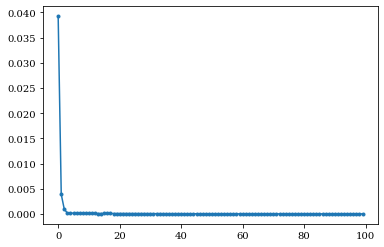

<Figure size 432x288 with 0 Axes>

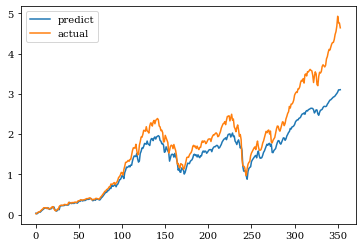

In [5]:
# 損失のグラフ化
loss = hist.history['loss']
epochs = len(loss)
plt.rc('font', family='serif')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(range(epochs), loss, marker='.', label='loss(training data)')
nov_dir = 'Colab Notebooks/workspace/'  # このフォルダへのパス
nov_path = '/content/drive/My Drive/' + nov_dir + 'ex_fc1_1.png'

plt.savefig(nov_path)
plt.show()
plt.close('all')

# 予測結果
predicted = model.predict(X_test)
result = pd.DataFrame(predicted)
result.columns = ['predict']
result['actual'] = y_test

plt.figure()
result.plot()
nov_dir = 'Colab Notebooks/workspace/'  # このフォルダへのパス
nov_path = '/content/drive/My Drive/' + nov_dir + 'ex_fc1_2.png'

plt.savefig(nov_path)
plt.show()
plt.close('all')
